In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%reload_ext spaudiopy
import spaudiopy as spa

In [2]:
default_figsize = (3.39, 3.0)
plt.rcParams['figure.figsize'] = default_figsize
font = {'family' : 'serif',
        'size'   : 9}
plt.rc('font', **font)
#plt.rcParams['axes.labelsize'] = 8
#plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 9

First, define sectors uniformly covering the sphere.

In [3]:
# CHOOSE HERE:
N_sph_sec = 3  # sector order
ENREC = False  # amplitude or energy reconstruction

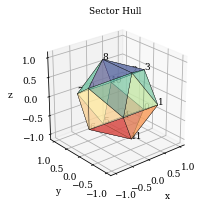

In [4]:
# steering of sectors
sec_vecs = spa.grids.load_t_design(2*N_sph_sec if ENREC else N_sph_sec+1)  # N+1 or 2N
sec_azi, sec_colat, _ = spa.utils.cart2sph(*sec_vecs.T)
# number of sectors
J_sec = len(sec_vecs)

fig = plt.figure()
spa.plots.hull(spa.decoder.get_hull(*sec_vecs.T), title="Sector Hull", fig=fig)
plt.savefig('hull.pdf')

In [5]:
def cardiod_beamweights(N_sph):
    """Differential beamformer resulting in a cardiod.
    Note: 4pi to compensate for correct normalization, unit amplitude."""
    c_n = np.array([(np.math.factorial(N_sph)*np.math.factorial(N_sph)) /
                    (np.math.factorial(N_sph+n+1) * np.math.factorial(N_sph-n))
                    for n in range(N_sph+1)])
    return 4*np.pi*c_n


def hypercardiod_beamweights(N_sph):
    """Differential beamformer resulting in a hyper-cardiod. Also called max-DI or normalized PWD.
    Rafaeli eq.6.10."""
    c_n = np.repeat((4*np.pi)/(N_sph+1)**2, N_sph+1)
    return c_n


def maxre_beamweights(N_sph, UNIT=True):
    """Differential beamformer resulting with max-rE weighting.
    Note: compensated for unit amplitude!"""
    c_n = spa.sph.max_rE_weights(N_sph)
    # there must be a better way. Axis symmetric pattern, not dependent on omega.
    #This is an iSHT in the same direction as unit PW
    #a = (np.diag(spa.sph.repeat_order_coeffs(c_n)) @ spa.sph.sh_matrix(N_sph_sec, 0, 0, 'real').T).T @ spa.sph.sh_matrix(N_sph_sec, 0, 0, 'real').T
    # turns out to be in SH domain:
    #a = spa.sph.bandlimited_dirac(N_sph, 0, c_n) if UNIT else 1
    if UNIT:
        c_n = spa.sph.unity_gain(c_n)
    return c_n


In [6]:
# CHOOSE HERE:
#c_n = cardiod_beamweights(N_sph_sec)
#c_n = hypercardiod_beamweights(N_sph_sec)
c_n = maxre_beamweights(N_sph_sec)  # works with amplitude compensation and without!

w_sec_nm = spa.sph.repeat_per_order(c_n) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real')

In [7]:
def directivity_factor(f_nm):
    """Directivity of spatial filter in SH domain.
    (eq.33)[Politis, A., & Pulkki, V. (2016).
    Acoustic intensity, energy-density and diffuseness estimation in a directionally-constrained region.]
    """
    f_nm = spa.utils.asarray_1d(f_nm)
    return np.real_if_close((4*np.pi)/(f_nm.conj().T@f_nm))

In [8]:
sector_q = directivity_factor(w_sec_nm[0, :])
print("Directivity:", sector_q)
spa.utils.test_diff(sector_q, 2*N_sph_sec + 1, "Cardiods:")  # analytic for cardioids: (2N+1)
spa.utils.test_diff(sector_q, (N_sph_sec + 1)**2, "Hyper-Cardioids")  # analytic for PWD: (N+1)^2

Directivity: 13.394050004520835
Cardiods: -- Diff:  6.394050004520835
Hyper-Cardioids -- Diff:  2.6059499954791647


2.6059499954791647

Look at the first few sector patterns.

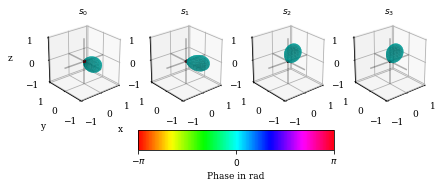

In [9]:
fig = plt.figure(figsize=(7, 3.3))
spa.plots.sh_coeffs_subplot([w_sec_nm[0, :], w_sec_nm[1, :],
                             w_sec_nm[2, :], w_sec_nm[2, :]],
                            titles=["$s_0$", "$s_1$", "$s_2$", "$s_3$"], 
                            fig=fig)
plt.savefig('sectors.pdf')

Next, testing the energy and amplitude preserving properties of sector patterns.
For that it's easier to go back to discrete domain, sum there, and then go back.

So, for amplitude

$
w0_{nm} = SHT[\sum_s^S \beta_a iSHT[ws_{nm}]]
$,

and energy

$
w0_{nm} = SHT[\sum_s^S \beta_e (|iSHT[ws_{nm}]|)^2]
$.

The factor $\beta$ ensures either amplitude or energy preservation.

In [10]:
# iSHT to discrete domain
trans_azi, trans_colat, _ = spa.utils.cart2sph(*spa.grids.load_t_design(2*N_sph_sec).T)
secs = spa.sph.inverse_sht(w_sec_nm.T, trans_azi, trans_colat, 'real')

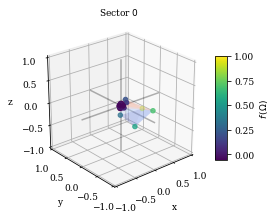

In [11]:
spa.plots.spherical_function(secs[:, 0], trans_azi, trans_colat, title='Sector $0$')

Beta_e -- Close enough.
Reconstruction 0 -- Close enough.


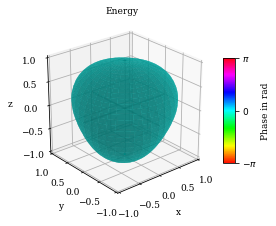

In [12]:
# energy beta factor
#beta_e = sector_q/J_sec
beta_e = 1/ (w_sec_nm[0, :].conj()@w_sec_nm[0, :]/np.sqrt(4*np.pi) * J_sec/np.sqrt(4*np.pi))
# test alternative
spa.utils.test_diff(beta_e, sector_q/J_sec, "Beta_e")

# Energy Reconstruction
w0_e = spa.sph.sht(beta_e*np.sum(abs(secs)**2, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
spa.utils.test_diff(w0_e[0], np.sqrt(4*np.pi), "Reconstruction 0")
spa.plots.sh_coeffs(w0_e, title="Energy")

Beta_a -- Close enough.
Beta_a = Beta_e -- Diff:  0.3853309040248679
Reconstruction 0 -- Close enough.


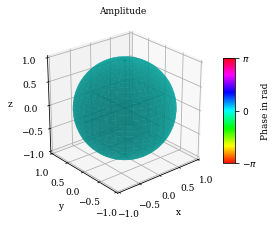

In [13]:
# amplitude beta factor
#beta_a = (N_sph_sec+1)/J_sec  # only cardioids
#beta_a = 1/ (w_sec_nm[0, 0]*np.sqrt(4*np.pi)/np.sqrt(4*np.pi) * J_sec/np.sqrt(4*np.pi))
#beta_a = 4*np.pi / (c_n[0] * J_sec)
beta_a = np.sqrt(4*np.pi)/ (w_sec_nm[0, 0] * J_sec)
# test alternative
spa.utils.test_diff(beta_a,  4*np.pi / (c_n[0] * J_sec), "Beta_a")
spa.utils.test_diff(beta_a, beta_e, "Beta_a = Beta_e")  # True for PWD!

# Amplitude Reconstruction
w0_a = spa.sph.sht(np.sum(beta_a*secs, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
spa.utils.test_diff(w0_a[0], np.sqrt(4*np.pi), "Reconstruction 0")
spa.plots.sh_coeffs(w0_a, title="Amplitude")

In [14]:
# Check full reconstruction
spa.utils.test_diff(np.sum(w0_a), np.sqrt(4*np.pi), "Amplitude reconstruction")
spa.utils.test_diff(np.sum(w0_e), np.sqrt(4*np.pi), "Energy reconstruction")
# ensured by not always up to 1, e.g. in case of grid higher 2N
print("sector max:", np.round(np.real_if_close(np.max(secs, axis=0)), 3))

Amplitude reconstruction -- Close enough.
Energy reconstruction -- Diff:  0.16302758635870385
sector max: [0.889 0.889 0.889 0.889 0.889 0.889 0.889 0.889 0.889 0.889 0.889 0.889]


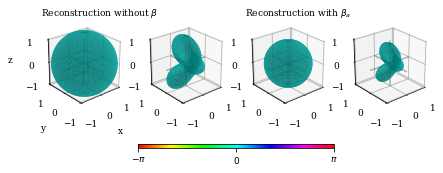

In [15]:
# Amplitude Reconstruction
w0_a_with = spa.sph.sht(np.sum(beta_a*secs, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
w0_a_without = spa.sph.sht(np.sum(1*secs, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
w_part_without = spa.sph.sht(np.sum(secs[:, ::2], axis=1),
                     N_sph_sec, trans_azi, trans_colat, 'real')
w_part_with = spa.sph.sht(beta_a*np.sum(secs[:, ::2], axis=1),
                     N_sph_sec, trans_azi, trans_colat, 'real')

fig = plt.figure(figsize=(7, 3.))
spa.plots.sh_coeffs_subplot([w0_a_without, w_part_without, w0_a_with, w_part_with],
                            fig=fig, azi_steps=2, el_steps=2)
# custom stuff
cbar = fig.get_axes()[-1]
cbar.set_aspect(1/50)  # cbar
cbar.set_xlabel(None)  # little hack bc of horizontal cbar

fig.axes[0].set_title(r"Reconstruction without $\beta$", loc='left')
fig.axes[2].set_title(r"Reconstruction with $\beta_a$", loc='left')
plt.savefig('reconstruction_withandwithout.pdf')

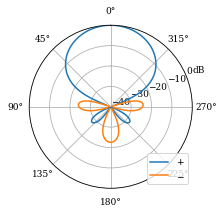

In [16]:
# cross section
cross_azi = np.linspace(0, 2 * np.pi, 720, endpoint=True)

# Bandlimited Dirac pulse
dirac_bandlim = spa.sph.bandlimited_dirac(N_sph_sec,cross_azi, c_n)

spa.plots.polar(cross_azi, dirac_bandlim)
plt.savefig('sectors_cross.pdf')

In [17]:
def sh_coeffs_overlay(F_nm_list, SH_type=None, azi_steps=5, el_steps=3, title=None,
              fig=None):
    """Plot spherical harmonics coefficients as function on the sphere.

    Examples
    --------
    See :py:mod:`spaudiopy.sph`

    """
    azi_steps = np.deg2rad(azi_steps)
    el_steps = np.deg2rad(el_steps)
    phi_plot, theta_plot = np.meshgrid(np.arange(0., 2 * np.pi + azi_steps,
                                                 azi_steps),
                                       np.arange(10e-3, np.pi + el_steps,
                                                 el_steps))

    if fig is None:
        fig = plt.figure(constrained_layout=True)
    ax = fig.gca(projection='3d')

    #m = cm.ScalarMappable(cmap=cm.hsv,
    #                      norm=colors.Normalize(vmin=-np.pi, vmax=np.pi))
    #m.set_array(f_ang)
    #c = m.to_rgba(f_ang.reshape(phi_plot.shape))
    #ax.set_prop_cycle('color', plt.cm.Spectral(np.linspace(0,1,len(F_nm_list))))
    cols = plt.cm.get_cmap('Set1_r')(np.linspace(0,1,len(F_nm_list)))
    
    for idx, F_nm in enumerate(F_nm_list):
        F_nm = spa.utils.asarray_1d(F_nm)
        F_nm = F_nm[:, np.newaxis]
        if SH_type is None:
            SH_type = 'complex' if np.iscomplexobj(F_nm) else 'real'
        f_plot = spa.sph.inverse_sht(F_nm, phi_plot.ravel(), theta_plot.ravel(),
                                     SH_type)
        f_r = np.abs(f_plot)
        f_ang = np.angle(f_plot)

        x_plot, y_plot, z_plot = spa.utils.sph2cart(phi_plot.ravel(),
                                                theta_plot.ravel(),
                                                f_r.ravel())
        ax.plot_surface(x_plot.reshape(phi_plot.shape),
                        y_plot.reshape(phi_plot.shape),
                        z_plot.reshape(phi_plot.shape),
                        #facecolors=c,
                        color=cols[idx, :],
                        edgecolor=(0.6, 0.6, 0.6, 0.6), linewidth=0.06, alpha=0.38, shade=True)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    # Draw axis lines
    x0 = np.array([1, 0, 0])
    y0 = np.array([0, 1, 0])
    z0 = np.array([0, 0, 1])
    for i in range(3):
        ax.plot([-x0[i], x0[i]], [-y0[i], y0[i]], [-z0[i], z0[i]], 'k',
                alpha=0.3)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.locator_params(nbins=5)

    #cb = plt.colorbar(m, ticks=[-np.pi, 0, np.pi], shrink=0.5, aspect=10)
    #cb.set_label("Phase in rad")
    #cb.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])

    plt.grid(True)
    spa.plots.set_aspect_equal3d(ax)
    ax.view_init(25, 230)
    if title is not None:
        plt.title(title)

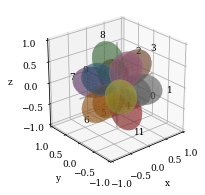

In [18]:
fig = plt.figure()
sh_coeffs_overlay([*w_sec_nm], fig=fig, azi_steps=2, el_steps=2)  # title="Sector Patterns"
# loudspeaker no
ax = plt.gca()
for s, co in enumerate(np.c_[spa.utils.sph2cart(sec_azi, sec_colat, 1.1)]):
    ax.text(co[0], co[1], co[2], s)
plt.savefig('sectors_overlay.pdf')

In [19]:
# Evaluation
from numpy.random import default_rng
rng = default_rng()

fs = 48000
in_nm_diff = 1 * rng.standard_normal((3*fs, (N_sph_sec+1)**2))
in_nm_pw1 = 1 * rng.standard_normal((3*fs, 1)) * spa.sph.sh_matrix(N_sph_sec, sec_azi[0], sec_colat[0], 'real')
in_nm_pw2 = 1 * rng.standard_normal((3*fs, 1)) * spa.sph.sh_matrix(N_sph_sec, sec_azi[2], sec_colat[2], 'real')

in_nm = in_nm_diff + in_nm_pw1 + in_nm_pw2

In [20]:
def rms(X, axis=0):
    return np.sqrt(np.mean(np.square(np.abs(X)), axis=axis))

In [21]:
in_sec = in_nm @ w_sec_nm.T  # discrete domain
print(rms(in_nm))
print(rms(in_sec))

[1.07739003 1.03021819 1.11237426 1.08275494 1.00154451 1.11376276
 1.07075735 1.11259346 1.08668867 1.00330168 0.99925927 1.18110835
 1.0640428  1.00988887 1.18681528 1.06528694]
[1.38897371 0.97108528 1.39424193 0.97411877 0.97110439 0.97569018
 0.97105052 0.96799814 0.96884853 0.97225176 0.97406995 0.97230866]


In [22]:
p_rms_ref = rms(in_nm[:, 0])
print("REF:", p_rms_ref)
p_rms_without = (1/np.sqrt(4*np.pi) * rms(1 * np.sum(in_sec, axis=1)))
print("WO:", p_rms_without)
p_rms_with = (1/np.sqrt(4*np.pi) * rms(beta_a * np.sum(in_sec, axis=1)))
print("With:", p_rms_with)

REF: 1.0773900294027396
WO: 1.4741805772254526
With: 1.0773900294027394


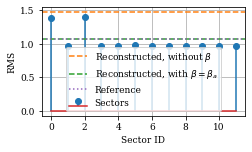

In [23]:
fig, ax = plt.subplots(figsize=(default_figsize[0], 2/3*default_figsize[1]), constrained_layout=True)
ax.stem(rms(in_sec), label='Sectors')

ax.axhline(p_rms_without, color='C1', linestyle='dashed', label=r'Reconstructed, without $\beta$')
ax.axhline(p_rms_with, color='C2', linestyle='dashed', label=r'Reconstructed, with $\beta=\beta_a$')
ax.axhline(p_rms_ref, color='C4', linestyle='dotted', label='Reference')

#plt.ylim([0., 1.5])
plt.xlabel('Sector ID')
plt.ylabel('RMS')
plt.legend()
plt.grid('on')
plt.savefig('evaluation.pdf')